In [14]:
from typing import Annotated, TypedDict, List
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4

load_dotenv()

llm=ChatGroq(model="llama3-8b-8192")


In [15]:
search_tool = TavilySearchResults(max_results=3)

tools=[search_tool]

memory=MemorySaver()


In [16]:
llm_with_tools=llm.bind_tools(tools=tools)

In [25]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: AgentState):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(AgentState)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        END: END,
    })
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

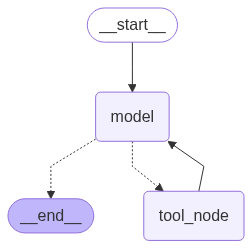

In [26]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {
    "configurable": {
        "thread_id": 1,
    }
}

# async_generator
events = graph.astream_events({
    "messages": [HumanMessage(content="Do u remember me!")],
    }, config=config, version="v2")

async for event in events:
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Do u remember me!', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '60444c4d-3127-499f-833e-c4140055fab6', 'metadata': {'thread_id': 1}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='How r u doing?', additional_kwargs={}, response_metadata={}, id='68a7a19a-fe0c-4966-bdf1-7d24b8b25146'), HumanMessage(content='How r u doing?', additional_kwargs={}, response_metadata={}, id='63670848-a4a6-4773-b6e0-cc789a4c9879'), AIMessage(content="I'm doing well, thank you for asking!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1893, 'total_tokens': 1904, 'completion_time': 0.017998487, 'prompt_time': 0.210736991, 'queue_time': -0.318814871, 'total_time': 0.228735478}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'stop', 'logpro